# Team Strength Analysis

We want to figure out a way to measure the strength of a team over the course of a season, so that we can factor it into future analyses and models. Eventually, it would be good to have a model of a team's strength that can change from GW to GW, but right now we will focus our efforts on identifying an aggregate metric, i.e. that measures the average strength of the team over a season. The strength of a team is broken down into attacking and defensive strength. Ultimately, the way we'll measure attacking strength is goals scored over the whole season, and defensive by goals conceded over the whole season. Therefore, we want to find a metric that's highly correlated with the total goals scored and conceded over the season. This metric will probably be separate for home and away fixtures, as home fixtures give a team a greater chance of winning a match.

There are a number of metrics already available in FPL:

1. **Fixture Difficulty Rating (FDR):** The FDR is based on a complex algorithm developed by FPL experts. A set of formulas process key Opta data variables, along with each team's home and away form for the past six matches, to generate a rank for the perceived difficulty of each Gameweek opponent. The FDR is designed to help FPL managers plan their transfer and team selection strategy. It is said to be reviewed on a weekly basis and updated as the season progresses - however a quick look at the data shows this is not true. The FDR is set at the start of the season and does not change. Some teams have separate FDRs for Home and Away games, most have the same FDR for both.

From our dataset, we also have a file called `teams.csv`, which is uploaded at the start of the season and is not updated as the season progresses. In this file, the following metrics are available:

2. **Strength attack/defence home:** Continuous variable.

3. **Strength attack/defence away:** Continuous variable.

This file is sourced directly from the Fantasy PL API, however I have not been able to find any explanation for how these metrics are calculated. 

Using data from the past 3 seasons, we will check how correlated each of these metrics are with the total goals scored/conceded for a given team in that season. The metric(s) with the highest correlation will be used going forward to control for team's attacking and defensive strength

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kendalltau, pearsonr

# Load and pre-process data

Load fixtures data from each season, join with the attacking/defensive strength metric and concatenate the results from each season.

In [2]:
away_data = None
home_data = None

for year in ['2020-21','2021-22','2022-23']:
    fixtures_path = f'../data/Fantasy-Premier-League/data/{year}/fixtures.csv'
    fixtures = pd.read_csv(fixtures_path)
    teams_path = f'../data/Fantasy-Premier-League/data/{year}/teams.csv'
    teams = pd.read_csv(teams_path)
    
    if away_data is None:
        away_data = fixtures.loc[:,['team_a','team_a_score','team_h_score','team_h_difficulty']]
        away_data = away_data.merge(teams.loc[:,['id','short_name','strength_attack_home','strength_defence_home',
                                         'strength_attack_away','strength_defence_away']], left_on='team_a',right_on='id',how='inner')
        away_data.rename(columns={'team_a_score':'goals_scored','team_h_score':'goals_conceded','team_h_difficulty':'FDR_rank'},inplace=True)
        away_data['team_name'] = f'{year}_' + away_data.short_name
        away_data.drop(columns=['team_a','id','short_name'],inplace=True)
        
        home_data = fixtures.loc[:,['team_h','team_h_score','team_a_score','team_a_difficulty']]
        home_data = home_data.merge(teams.loc[:,['id','short_name','strength_attack_home','strength_defence_home',
                                         'strength_attack_away','strength_defence_away']], left_on='team_h',right_on='id',how='inner')
        home_data.rename(columns={'team_h_score':'goals_scored','team_a_score':'goals_conceded','team_a_difficulty':'FDR_rank'},inplace=True)
        home_data['team_name'] = f'{year}_' + home_data.short_name
        home_data.drop(columns=['team_h','id','short_name'],inplace=True)
        
    else: 
        temp_a = fixtures.loc[:,['team_a','team_a_score','team_h_score','team_h_difficulty']]
        temp_a = temp_a.merge(teams.loc[:,['id','short_name','strength_attack_home','strength_defence_home',
                                         'strength_attack_away','strength_defence_away']], left_on='team_a',right_on='id',how='inner')
        temp_a.rename(columns={'team_a_score':'goals_scored','team_h_score':'goals_conceded','team_h_difficulty':'FDR_rank'},inplace=True)
        temp_a['team_name'] = f'{year}_' + temp_a.short_name
        temp_a.drop(columns=['team_a','id','short_name'],inplace=True)
        
        temp_h = fixtures.loc[:,['team_h','team_h_score','team_a_score','team_a_difficulty']]
        temp_h = temp_h.merge(teams.loc[:,['id','short_name','strength_attack_home','strength_defence_home',
                                         'strength_attack_away','strength_defence_away']], left_on='team_h',right_on='id',how='inner')
        temp_h.rename(columns={'team_h_score':'goals_scored','team_a_score':'goals_conceded','team_a_difficulty':'FDR_rank'},inplace=True)
        temp_h['team_name'] = f'{year}_' + temp_h.short_name
        temp_h.drop(columns=['team_h','id','short_name'],inplace=True)
        
        away_data = pd.concat([away_data,temp_a])
        home_data = pd.concat([home_data,temp_h])

In [3]:
away_data

,goals_scored,goals_conceded,FDR_rank,strength_attack_home,strength_defence_home,strength_attack_away,strength_defence_away,team_name
0,3,0,3,1130,1220,1150,1210,2020-21_ARS
1,1,3,3,1130,1220,1150,1210,2020-21_ARS
2,0,1,3,1130,1220,1150,1210,2020-21_ARS
3,1,0,3,1130,1220,1150,1210,2020-21_ARS
4,0,0,3,1130,1220,1150,1210,2020-21_ARS
...,...,...,...,...,...,...,...,...
375,5,1,2,1110,1060,1110,1090,2022-23_CRY
376,2,0,2,1110,1060,1110,1090,2022-23_CRY
377,0,2,2,1110,1060,1110,1090,2022-23_CRY
378,0,1,2,1110,1060,1110,1090,2022-23_CRY


In [4]:
home_data

,goals_scored,goals_conceded,FDR_rank,strength_attack_home,strength_defence_home,strength_attack_away,strength_defence_away,team_name
0,0,3,2,1150,1040,1110,1060,2020-21_FUL
1,0,3,2,1150,1040,1110,1060,2020-21_FUL
2,1,2,2,1150,1040,1110,1060,2020-21_FUL
3,2,0,2,1150,1040,1110,1060,2020-21_FUL
4,2,3,2,1150,1040,1110,1060,2020-21_FUL
...,...,...,...,...,...,...,...,...
375,3,2,4,1180,1260,1250,1300,2022-23_LIV
376,4,3,4,1180,1260,1250,1300,2022-23_LIV
377,1,0,4,1180,1260,1250,1300,2022-23_LIV
378,1,0,4,1180,1260,1250,1300,2022-23_LIV


In [5]:
home_data = home_data.groupby(by='team_name').mean()
home_data.FDR_rank = home_data.FDR_rank.astype(int)
home_data.strength_attack_home = home_data.strength_attack_home.astype(int)
home_data.strength_defence_home = home_data.strength_defence_home.astype(int)
home_data.strength_attack_away = home_data.strength_attack_away.astype(int)
home_data.strength_defence_away = home_data.strength_defence_away.astype(int)
home_data

,goals_scored,goals_conceded,FDR_rank,strength_attack_home,strength_defence_home,strength_attack_away,strength_defence_away
team_name,,,,,,,
2020-21_ARS,1.263158,1.105263,4,1130,1220,1150,1210
2020-21_AVL,1.526316,1.421053,3,1120,1080,1140,1100
2020-21_BHA,1.157895,1.157895,3,1150,1100,1190,1130
2020-21_BUR,0.736842,1.421053,2,1040,1040,1090,1080
2020-21_CHE,1.631579,0.947368,4,1260,1250,1300,1310
2020-21_CRY,1.052632,1.684211,3,1030,1010,1120,1020
2020-21_EVE,1.263158,1.473684,3,1130,1200,1100,1140
2020-21_FUL,0.473684,1.473684,2,1150,1040,1110,1060
2020-21_LEE,1.473684,1.105263,3,1060,1210,1150,1170


In [6]:
away_data = away_data.groupby(by='team_name').mean()
away_data.FDR_rank = away_data.FDR_rank.astype(int)
away_data.strength_attack_home = away_data.strength_attack_home.astype(int)
away_data.strength_defence_home = away_data.strength_defence_home.astype(int)
away_data.strength_attack_away = away_data.strength_attack_away.astype(int)
away_data.strength_defence_away = away_data.strength_defence_away.astype(int)
away_data

,goals_scored,goals_conceded,FDR_rank,strength_attack_home,strength_defence_home,strength_attack_away,strength_defence_away
team_name,,,,,,,
2020-21_ARS,1.631579,0.947368,3,1130,1220,1150,1210
2020-21_AVL,1.368421,1.000000,2,1120,1080,1140,1100
2020-21_BHA,0.947368,1.263158,3,1150,1100,1190,1130
2020-21_BUR,1.000000,1.473684,2,1040,1040,1090,1080
2020-21_CHE,1.421053,0.947368,4,1260,1250,1300,1310
2020-21_CRY,1.105263,1.789474,2,1030,1010,1120,1020
2020-21_EVE,1.210526,1.052632,4,1130,1200,1100,1140
2020-21_FUL,0.947368,1.315789,2,1150,1040,1110,1060
2020-21_LEE,1.789474,1.736842,3,1060,1210,1150,1170


# 1. Fixture Difficulty Rating (FDR)

## Measuring Attacking and Defensive Strength at Home with FDR:

We will visualise the relationship with boxplots, before calculating Kendall's tau coefficient to measure the correlation between home goals scored/conceded and the FDR rank. We are using Kendall's tau-b because the FDR rank is an ordinal variable (rank from 1 to 5) and the average goals scored/conceded per match is a numeric variable.

### Visualising the relationship

In [7]:
ranks = sorted(home_data.FDR_rank.unique())
h_goals_scored = []
h_goals_conceded = []
for rank in ranks:
    h_goals_scored.append(home_data.loc[home_data.FDR_rank == rank,'goals_scored'].values)
    h_goals_conceded.append(home_data.loc[home_data.FDR_rank == rank,'goals_conceded'].values)

C:\Users\Development\AppData\Local\Temp\ipykernel_9748\514337545.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_9748\514337545.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)


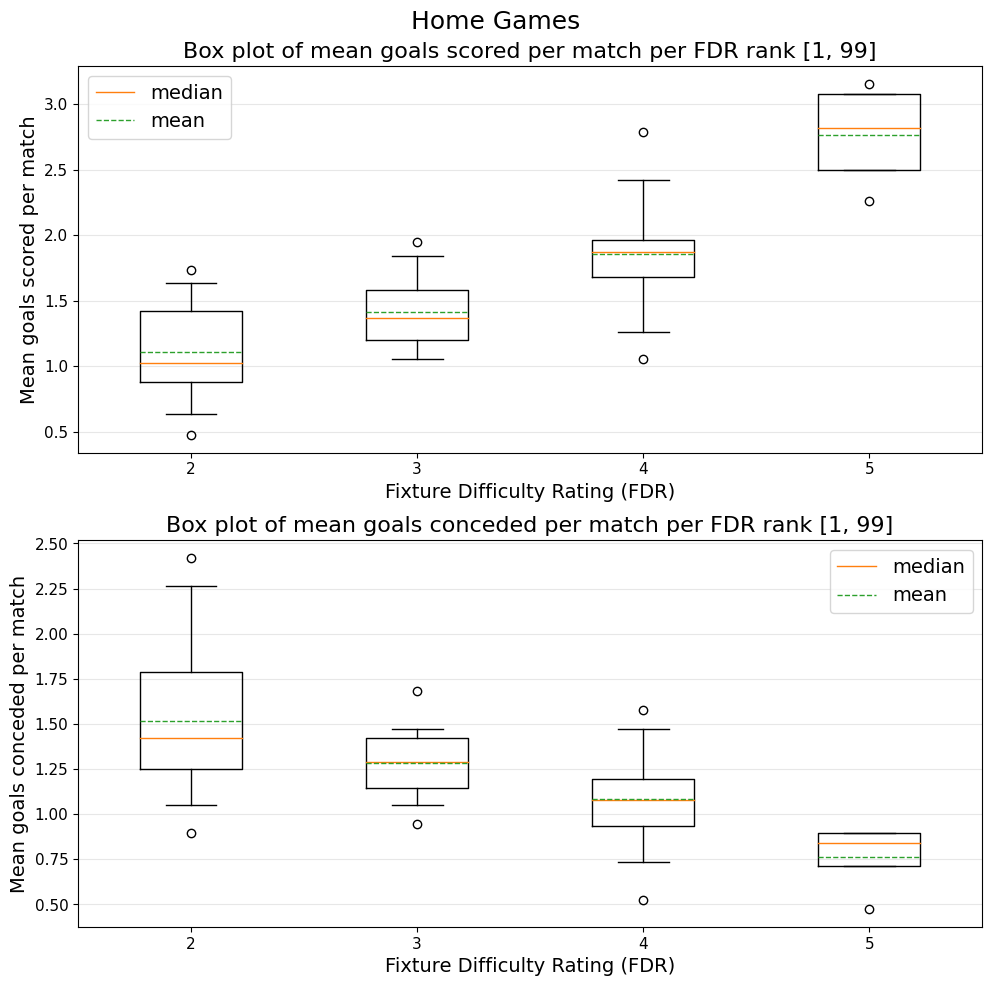

In [8]:
title_font = 18
axis_title_font = 16
legend_font = 14
axis_label_font = 14
axis_tick_font = 11

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))

box_dict = ax[0].boxplot(h_goals_scored, whis=(1,99), labels = ranks, meanline = True, showmeans = True)
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize = axis_tick_font)
_ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
ax[0].set_ylabel('Mean goals scored per match', fontsize = axis_label_font)
ax[0].set_xlabel('Fixture Difficulty Rating (FDR)', fontsize = axis_label_font)
ax[0].grid(axis = 'y', alpha = 0.3)
ax[0].legend([box_dict['medians'][0], box_dict['means'][0]], ['median', 'mean'], fontsize = legend_font)
ax[0].set_title('''Box plot of mean goals scored per match per FDR rank [1, 99]''', fontsize = axis_title_font)

box_dict = ax[1].boxplot(h_goals_conceded, whis=(1,99), labels = ranks, meanline = True, showmeans = True)
_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize = axis_tick_font)
_ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)
ax[1].set_ylabel('Mean goals conceded per match', fontsize = axis_label_font)
ax[1].set_xlabel('Fixture Difficulty Rating (FDR)', fontsize = axis_label_font)
ax[1].grid(axis = 'y', alpha = 0.3)
ax[1].legend([box_dict['medians'][0], box_dict['means'][0]], ['median', 'mean'], fontsize = legend_font)
ax[1].set_title('''Box plot of mean goals conceded per match per FDR rank [1, 99]''', fontsize = axis_title_font)

fig.suptitle('Home Games',fontsize=title_font)
fig.tight_layout(pad=1.0)
plt.savefig('./plots/FDR_goals_scored_conceded_home_boxplots.png', bbox_inches = 'tight')
plt.show()

### Measuring the correlation beween FDR and goals scored/conceded

In [9]:
print('Home data:')

result = kendalltau(home_data.FDR_rank, home_data.goals_scored, variant = 'b')
print(f'''Correlation between FDR and mean goals scored per match: {result.statistic}''')

result = kendalltau(home_data.FDR_rank, home_data.goals_conceded, variant = 'b')
print(f'''Correlation between FDR and mean goals conceded per match: {result.statistic}''')

Home data:
Correlation between FDR and mean goals scored per match: 0.622396345542709
Correlation between FDR and mean goals conceded per match: -0.4897195968191144


## Measuring Attacking and Defensive Strength Away with FDR:

### Visualising the relationship

In [10]:
ranks = sorted(away_data.FDR_rank.unique())
a_goals_scored = []
a_goals_conceded = []
for rank in ranks:
    a_goals_scored.append(away_data.loc[away_data.FDR_rank == rank,'goals_scored'].values)
    a_goals_conceded.append(away_data.loc[away_data.FDR_rank == rank,'goals_conceded'].values)

C:\Users\Development\AppData\Local\Temp\ipykernel_9748\1480215208.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_9748\1480215208.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)


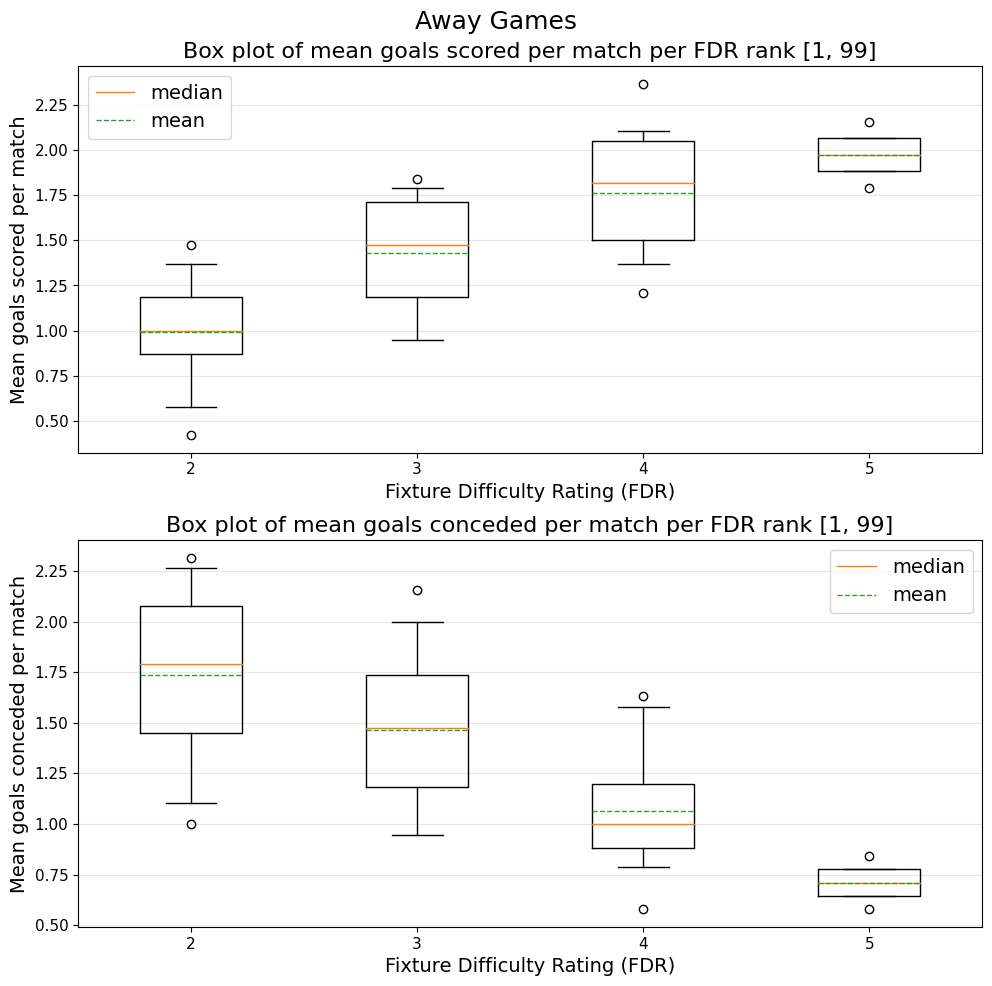

In [11]:
title_font = 18
axis_title_font = 16
legend_font = 14
axis_label_font = 14
axis_tick_font = 11

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))

box_dict = ax[0].boxplot(a_goals_scored, whis=(1,99), labels = ranks, meanline = True, showmeans = True)
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize = axis_tick_font)
_ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
ax[0].set_ylabel('Mean goals scored per match', fontsize = axis_label_font)
ax[0].set_xlabel('Fixture Difficulty Rating (FDR)', fontsize = axis_label_font)
ax[0].grid(axis = 'y', alpha = 0.3)
ax[0].legend([box_dict['medians'][0], box_dict['means'][0]], ['median', 'mean'], fontsize = legend_font)
ax[0].set_title('''Box plot of mean goals scored per match per FDR rank [1, 99]''', fontsize = axis_title_font)

box_dict = ax[1].boxplot(a_goals_conceded, whis=(1,99), labels = ranks, meanline = True, showmeans = True)
_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize = axis_tick_font)
_ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)
ax[1].set_ylabel('Mean goals conceded per match', fontsize = axis_label_font)
ax[1].set_xlabel('Fixture Difficulty Rating (FDR)', fontsize = axis_label_font)
ax[1].grid(axis = 'y', alpha = 0.3)
ax[1].legend([box_dict['medians'][0], box_dict['means'][0]], ['median', 'mean'], fontsize = legend_font)
ax[1].set_title('''Box plot of mean goals conceded per match per FDR rank [1, 99]''', fontsize = axis_title_font)

fig.suptitle('Away Games',fontsize=title_font)
fig.tight_layout(pad=1.0)
plt.savefig('./plots/FDR_goals_scored_conceded_away_boxplots.png', bbox_inches = 'tight')
plt.show()

### Plotting Home and Away data side by side

C:\Users\Development\AppData\Local\Temp\ipykernel_9748\1994621270.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0,0].set_yticklabels(ax[0,0].get_yticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_9748\1994621270.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0,1].set_yticklabels(ax[0,1].get_yticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_9748\1994621270.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1,0].set_yticklabels(ax[1,0].get_yticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_9748\1994621270.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1,1].set_yticklabels(ax[1,1].get_yticklabels(), fontsize = axis_tick_font)


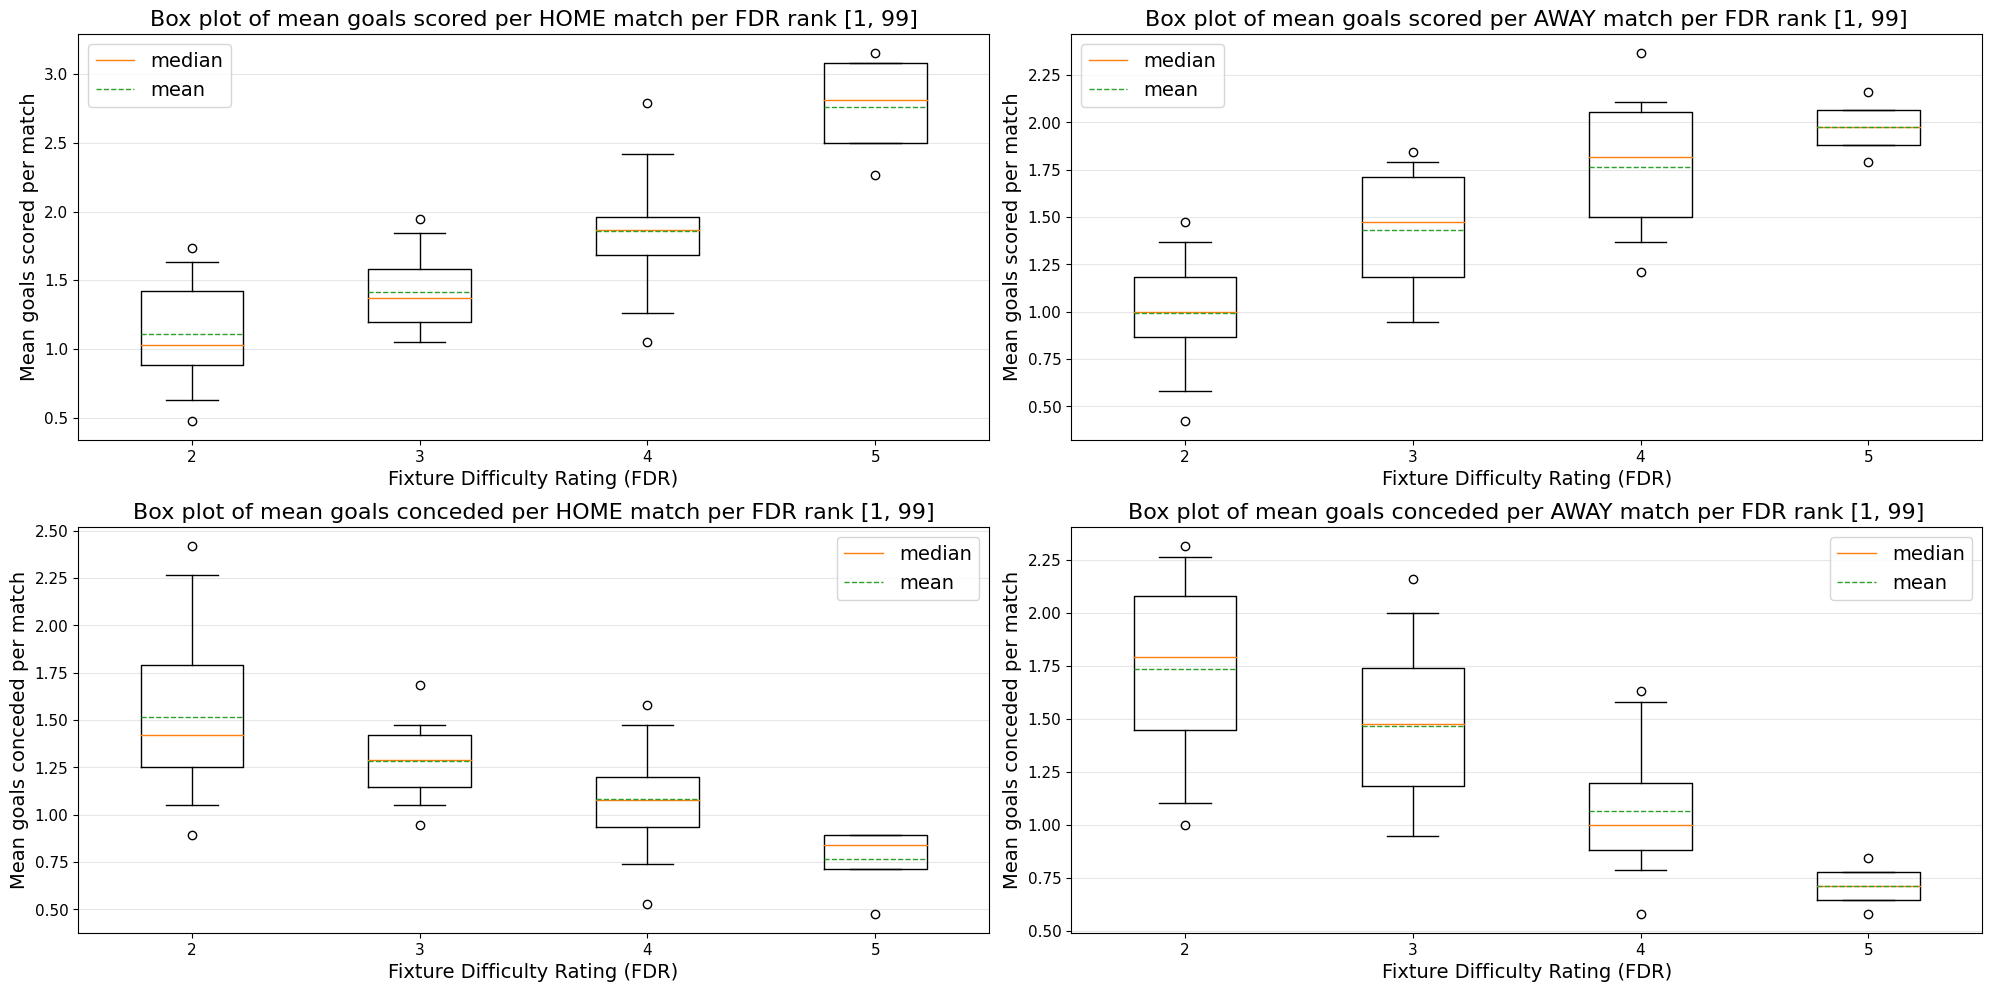

In [12]:
title_font = 18
axis_title_font = 16
legend_font = 14
axis_label_font = 14
axis_tick_font = 11

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(20,10))

box_dict = ax[0,0].boxplot(h_goals_scored, whis=(1,99), labels = ranks, meanline = True, showmeans = True)
_ = ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), fontsize = axis_tick_font)
_ = ax[0,0].set_yticklabels(ax[0,0].get_yticklabels(), fontsize = axis_tick_font)
ax[0,0].set_ylabel('Mean goals scored per match', fontsize = axis_label_font)
ax[0,0].set_xlabel('Fixture Difficulty Rating (FDR)', fontsize = axis_label_font)
ax[0,0].grid(axis = 'y', alpha = 0.3)
ax[0,0].legend([box_dict['medians'][0], box_dict['means'][0]], ['median', 'mean'], fontsize = legend_font)
ax[0,0].set_title('''Box plot of mean goals scored per HOME match per FDR rank [1, 99]''', fontsize = axis_title_font)

box_dict = ax[0,1].boxplot(a_goals_scored, whis=(1,99), labels = ranks, meanline = True, showmeans = True)
_ = ax[0,1].set_xticklabels(ax[0,1].get_xticklabels(), fontsize = axis_tick_font)
_ = ax[0,1].set_yticklabels(ax[0,1].get_yticklabels(), fontsize = axis_tick_font)
ax[0,1].set_ylabel('Mean goals scored per match', fontsize = axis_label_font)
ax[0,1].set_xlabel('Fixture Difficulty Rating (FDR)', fontsize = axis_label_font)
ax[0,1].grid(axis = 'y', alpha = 0.3)
ax[0,1].legend([box_dict['medians'][0], box_dict['means'][0]], ['median', 'mean'], fontsize = legend_font)
ax[0,1].set_title('''Box plot of mean goals scored per AWAY match per FDR rank [1, 99]''', fontsize = axis_title_font)

box_dict = ax[1,0].boxplot(h_goals_conceded, whis=(1,99), labels = ranks, meanline = True, showmeans = True)
_ = ax[1,0].set_xticklabels(ax[1,0].get_xticklabels(), fontsize = axis_tick_font)
_ = ax[1,0].set_yticklabels(ax[1,0].get_yticklabels(), fontsize = axis_tick_font)
ax[1,0].set_ylabel('Mean goals conceded per match', fontsize = axis_label_font)
ax[1,0].set_xlabel('Fixture Difficulty Rating (FDR)', fontsize = axis_label_font)
ax[1,0].grid(axis = 'y', alpha = 0.3)
ax[1,0].legend([box_dict['medians'][0], box_dict['means'][0]], ['median', 'mean'], fontsize = legend_font)
ax[1,0].set_title('''Box plot of mean goals conceded per HOME match per FDR rank [1, 99]''', fontsize = axis_title_font)

box_dict = ax[1,1].boxplot(a_goals_conceded, whis=(1,99), labels = ranks, meanline = True, showmeans = True)
_ = ax[1,1].set_xticklabels(ax[1,1].get_xticklabels(), fontsize = axis_tick_font)
_ = ax[1,1].set_yticklabels(ax[1,1].get_yticklabels(), fontsize = axis_tick_font)
ax[1,1].set_ylabel('Mean goals conceded per match', fontsize = axis_label_font)
ax[1,1].set_xlabel('Fixture Difficulty Rating (FDR)', fontsize = axis_label_font)
ax[1,1].grid(axis = 'y', alpha = 0.3)
ax[1,1].legend([box_dict['medians'][0], box_dict['means'][0]], ['median', 'mean'], fontsize = legend_font)
ax[1,1].set_title('''Box plot of mean goals conceded per AWAY match per FDR rank [1, 99]''', fontsize = axis_title_font)

fig.tight_layout(pad=1.0)
plt.savefig('./plots/FDR_goals_scored_conceded_home_away_boxplots.png', bbox_inches = 'tight')
plt.show()

## Measuring the correlation beween FDR and goals scored/conceded

In [13]:
print('Away data:')
result = kendalltau(away_data.FDR_rank, away_data.goals_scored, variant = 'b')
print(f'''Correlation between a team's FDR and mean goals scored per match: {result.statistic}''')

result = kendalltau(away_data.FDR_rank, away_data.goals_conceded, variant = 'b')
print(f'''Correlation between a team's FDR and mean goals conceded per match: {result.statistic}''')

Away data:
Correlation between a team's FDR and mean goals scored per match: 0.6200158579842635
Correlation between a team's FDR and mean goals conceded per match: -0.5049116196336118


# 2. Strength at Home

Since mean goals scored/conceded per match is a continuous numeric variable and the strength metric is a discrete numeric variable, we'll use Pearson's correlation coefficient to measure the strength of the relationship.

## Visualising the relationship

C:\Users\Development\AppData\Local\Temp\ipykernel_9748\2211349878.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_9748\2211349878.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_9748\2211349878.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_9748\2211349878.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)


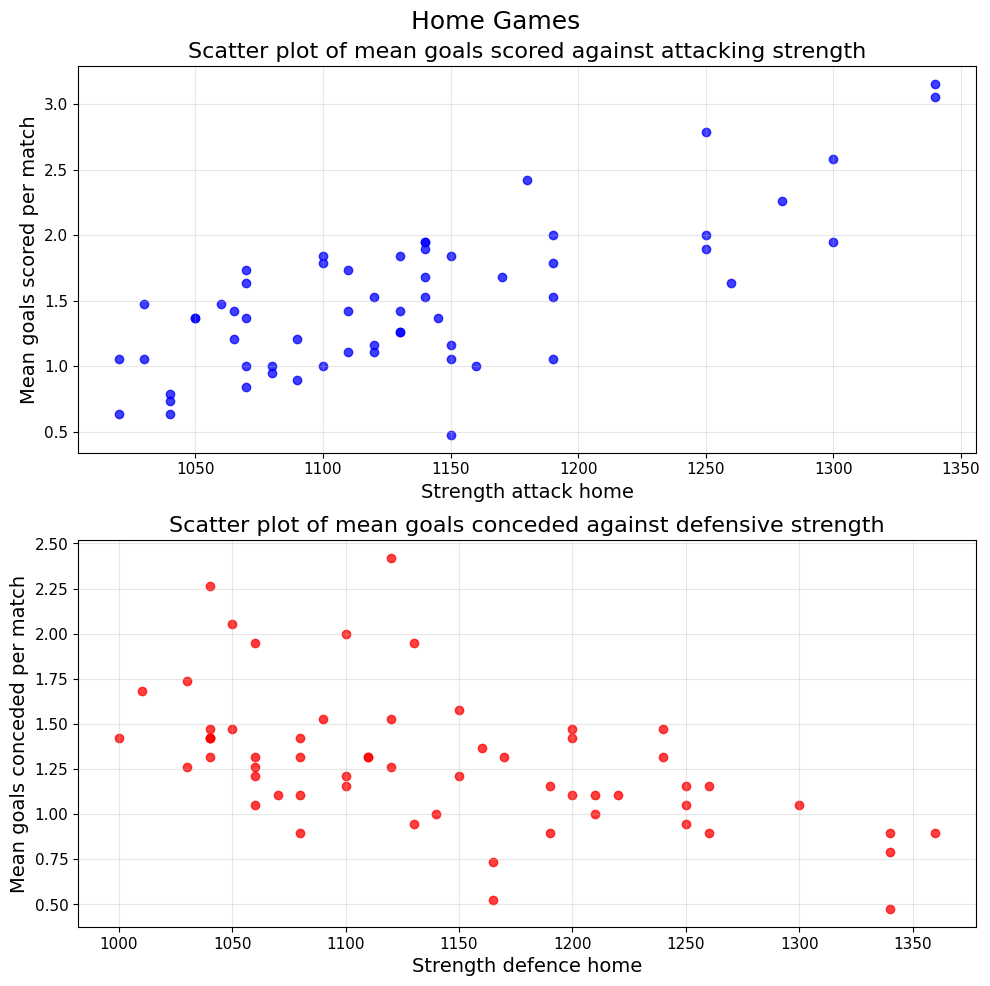

In [14]:
title_font = 18
axis_title_font = 16
legend_font = 14
axis_label_font = 14
axis_tick_font = 11

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))

ax[0].scatter(home_data.strength_attack_home, home_data.goals_scored, alpha = 0.75, color='b')
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize = axis_tick_font)
_ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
ax[0].set_ylabel('Mean goals scored per match', fontsize = axis_label_font)
ax[0].set_xlabel('Strength attack home', fontsize = axis_label_font)
ax[0].grid(alpha = 0.3)
ax[0].set_title('''Scatter plot of mean goals scored against attacking strength''', fontsize = axis_title_font)
#for i, txt in enumerate(home_data.short_name):
#    ax[0].annotate(txt, (home_data.strength_attack_home[i], home_data.goals_scored[i]), (home_data.strength_attack_home[i]+0.03, home_data.goals_scored[i]+0.03))

ax[1].scatter(home_data.strength_defence_home, home_data.goals_conceded, alpha = 0.75, color='r')
_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize = axis_tick_font)
_ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)
ax[1].set_ylabel('Mean goals conceded per match', fontsize = axis_label_font)
ax[1].set_xlabel('Strength defence home', fontsize = axis_label_font)
ax[1].grid(alpha = 0.3)
ax[1].set_title('''Scatter plot of mean goals conceded against defensive strength''', fontsize = axis_title_font)
#for i, txt in enumerate(home_data.short_name):
#    ax[1].annotate(txt, (home_data.strength_defence_home[i], home_data.goals_conceded[i]), (home_data.strength_defence_home[i]+0.03, home_data.goals_conceded[i]+0.03))

fig.suptitle('Home Games',fontsize=title_font)
fig.tight_layout(pad=1.0)
plt.savefig('./plots/home_attack_defence_scatter.png', bbox_inches = 'tight')
plt.show()

## Measuring the Correlation between strength and goals scored/conceded

In [15]:
print('Home data:')
result = pearsonr(home_data.strength_attack_home, home_data.goals_scored)
print(f'''Correlation between a team's attacking strength and mean goals scored per match: {result.statistic}''')

result = pearsonr(home_data.strength_defence_home, home_data.goals_conceded)
print(f'''Correlation between a team's defensive strength and mean goals conceded per match: {result.statistic}''')

Home data:
Correlation between a team's attacking strength and mean goals scored per match: 0.7386740203072897
Correlation between a team's defensive strength and mean goals conceded per match: -0.5272334769903623


# 3. Strength Away

## Visualising the relationship

C:\Users\Development\AppData\Local\Temp\ipykernel_9748\1654124651.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_9748\1654124651.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_9748\1654124651.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize = axis_tick_font)
C:\Users\Development\AppData\Local\Temp\ipykernel_9748\1654124651.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)


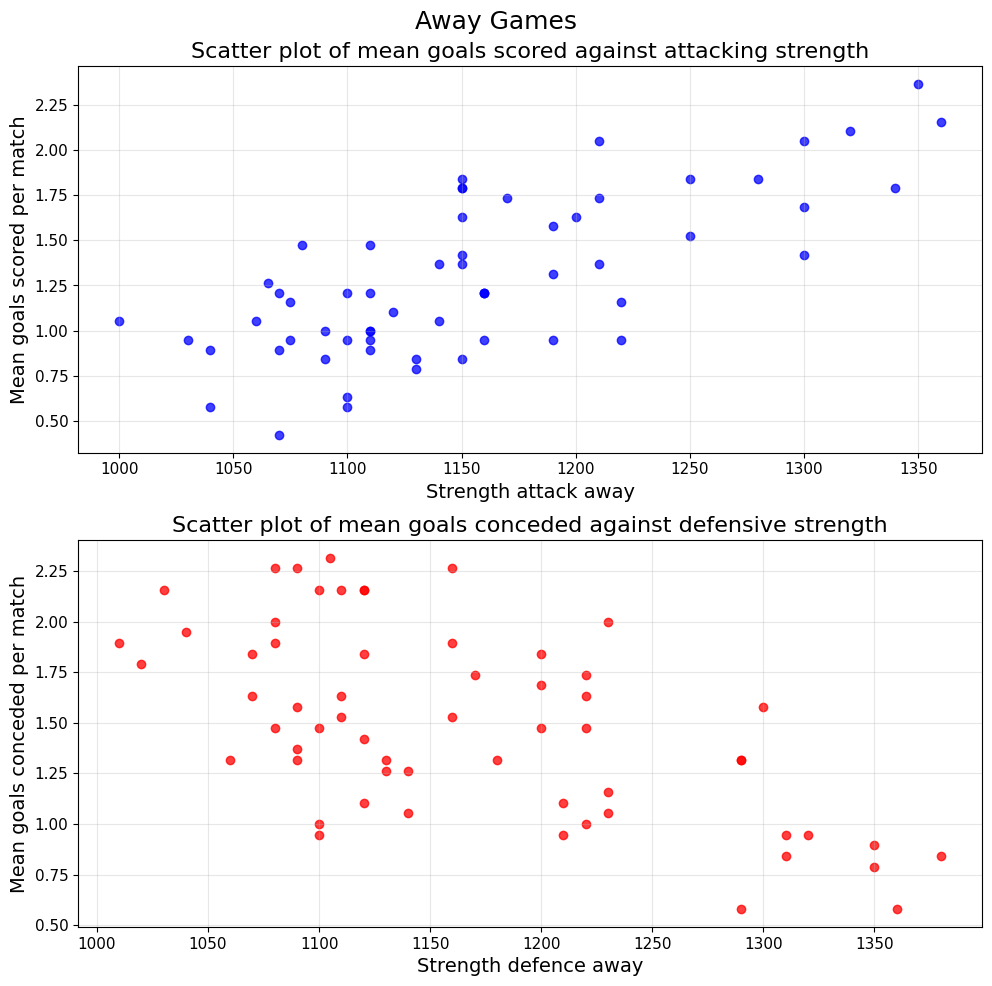

In [16]:
title_font = 18
axis_title_font = 16
legend_font = 14
axis_label_font = 14
axis_tick_font = 11

fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,10))

ax[0].scatter(away_data.strength_attack_away, away_data.goals_scored, alpha = 0.75, color='b')
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize = axis_tick_font)
_ = ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize = axis_tick_font)
ax[0].set_ylabel('Mean goals scored per match', fontsize = axis_label_font)
ax[0].set_xlabel('Strength attack away', fontsize = axis_label_font)
ax[0].grid(alpha = 0.3)
ax[0].set_title('''Scatter plot of mean goals scored against attacking strength''', fontsize = axis_title_font)
#for i, txt in enumerate(away_data.short_name):
#    ax[0].annotate(txt, (away_data.strength_attack_away[i], away_data.goals_scored[i]), (away_data.strength_attack_away[i]+0.03, away_data.goals_scored[i]+0.03))

ax[1].scatter(away_data.strength_defence_away, away_data.goals_conceded, alpha = 0.75, color='r')
_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize = axis_tick_font)
_ = ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize = axis_tick_font)
ax[1].set_ylabel('Mean goals conceded per match', fontsize = axis_label_font)
ax[1].set_xlabel('Strength defence away', fontsize = axis_label_font)
ax[1].grid(alpha = 0.3)
ax[1].set_title('''Scatter plot of mean goals conceded against defensive strength''', fontsize = axis_title_font)
#for i, txt in enumerate(away_data.short_name):
#    ax[1].annotate(txt, (away_data.strength_defence_away[i], away_data.goals_conceded[i]), (away_data.strength_defence_away[i]+0.03, away_data.goals_conceded[i]+0.03))

fig.suptitle('Away Games',fontsize=title_font)
fig.tight_layout(pad=1.0)
plt.savefig('./plots/away_attack_defence_scatter.png', bbox_inches = 'tight')
plt.show()

## Correlation

In [17]:
print('Away data:')
result = pearsonr(away_data.strength_attack_away, away_data.goals_scored)
print(f'''Correlation between a team's attacking strength and mean goals scored per match: {result.statistic}''')

result = pearsonr(away_data.strength_defence_away, away_data.goals_conceded)
print(f'''Correlation between a team's defensive strength and mean goals conceded per match: {result.statistic}''')

Away data:
Correlation between a team's attacking strength and mean goals scored per match: 0.732601363544569
Correlation between a team's defensive strength and mean goals conceded per match: -0.6131354692136175


# Conclusion

The results are summarised in the following table. Each cell shows the correlation of that metric with the mean goals scored/conceded for that event type (home/away):

| Event | FDR Attack| FDR Defence | Strength Attack | Strength Defence |
| --- | --- | --- | --- | --- |
| Home | 0.62 | -0.49 | 0.74 | -0.53|
| Away | 0.62 | -0.5 | 0.73 | -0.61 |

Clearly the strength metric is a better choice for measuring a team's attacking and defensive strength compared to the FDR. Which makes sense - as it allows more degrees of freedom than having 1 fixed number for measuring both attack and defence, as is the case for FDR.

Going forward, the strength metric will be used to control for a team's attacking and defensive strength when carrying out an analysis.